In [25]:
%reset -sf

from time import time
time_start = time()

import pandas as pd
import numpy as np
import scipy as sp
import gc
import os
from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf

# from pylorentz import Momentum4
# from mt2 import mt2

import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [26]:
seed = 42  # set random seed
sampling = int(1e6)
# num_folds = 2
batch_size = 128
epochs = 512
learning_rate = 1e-4

In [27]:
np.random.seed(seed)
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [28]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [29]:
lep_p = processor.process_part(data.LepP).iloc[:, :4]
lep_p.columns = ["lep_p_" + col.lower() for col in lep_p.columns]
lep_m = processor.process_part(data.LepM).iloc[:, :4]
lep_m.columns = ["lep_m_" + col.lower() for col in lep_m.columns]
w_p = processor.process_part(data.Wp).iloc[:, :4]
w_p.columns = ["w_p_" + col.lower() for col in w_p.columns]
w_m = processor.process_part(data.Wm).iloc[:, :4]
w_m.columns = ["w_m_" + col.lower() for col in w_m.columns]
met = processor.process_MET(data.MET).iloc[:, 1:3]
met.columns = ["met_px", "met_py"]
# dilep_kin = processor.process_dipart(data.LepP, data.LepM)
# mt2 = np.sqrt(
#     mt2(
#         lep_m["m"],
#         lep_m["px"],
#         lep_m["py"],  # Visible 1: mass, px, py
#         lep_p["m"],
#         lep_p["px"],
#         lep_p["py"],  # Visible 2: mass, px, py
#         MET["MET_px"],
#         MET["MET_py"],  # Missing transverse momentum: x, y
#         0,
#         0,  # Invisible 1 mass, invisible 2 mass
#     )
# )
# vx = 5 * pd.DataFrame({"vx": mt2 + 0.3 * np.sqrt(dilep_kin["m"])})
# dilep_kin.iloc[:, 0:4]
mask = (w_p["w_p_e"] < 600) & (w_m["w_m_e"] < 600) & cut_pre

obs_kin = pd.concat([met, lep_p, lep_m], axis=1)[mask]
print(type(obs_kin))
print("obs_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print()

# int_kin = pd.concat([w_p["w_p_e"], w_m["w_m_e"]], axis=1)[mask]
int_kin = pd.concat([w_p["w_p_e"]], axis=1)[mask]
print(type(int_kin))
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print()

# del (processor, lep_p, lep_m, met, dilep_kin, mt, vx)
# gc.collect()

<class 'pandas.core.frame.DataFrame'>
obs_kin shape: (1273311, 10)
       met_px     met_py     lep_p_e   lep_p_px   lep_p_py    lep_p_pz  \
7   96.335650  47.095450   19.500895  -4.561588  18.924410   -1.154271   
9  -26.992604 -70.883859  164.814766  34.397141   2.031300 -161.172625   
10  44.222846 -15.383637   47.669113 -26.605045 -17.256748   35.590859   

      lep_m_e   lep_m_px   lep_m_py   lep_m_pz  
7   43.361348  42.407754  -4.632000   7.767462  
9   70.592648  29.001777   1.896990 -64.332027  
10  90.238664 -23.868604  32.986602  80.530680  

<class 'pandas.core.frame.DataFrame'>
int_kin shape: (1273311, 1)
         w_p_e
7   165.084422
9   262.774094
10   55.093242



              w_p_e
count  1.273311e+06
mean   1.449612e+02
std    1.094361e+02
min    1.448061e+01
25%    7.197932e+01
50%    1.068312e+02
75%    1.801991e+02
max    5.999963e+02


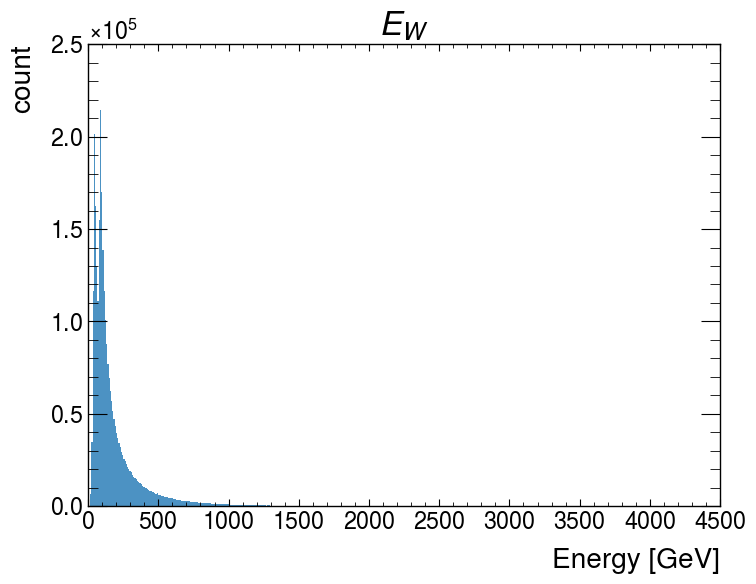

In [30]:
print(int_kin.describe())
plt.hist(w_p["w_p_e"], bins=500, alpha=.8)
plt.title(r"$E_{W}$")
plt.xlabel("Energy [GeV]")
plt.ylabel("count")
# plt.xlim([0,800])
plt.show()
# plt.hist(w_m["w_m_e"], bins=800, alpha=.8)
# plt.title(r"$E_{W^-}$")
# plt.xlabel("Energy [MeV]")
# plt.ylabel("count")
# # plt.xlim([0,800])
# plt.show()

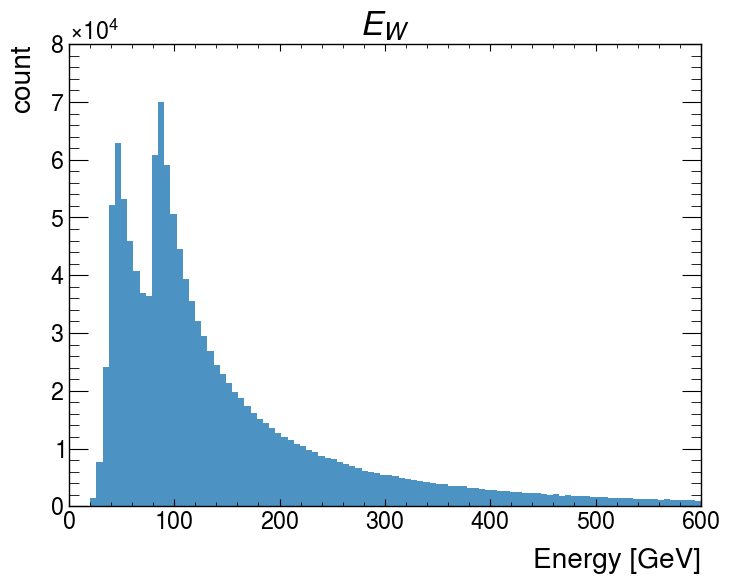

In [31]:
plt.hist(int_kin["w_p_e"], bins=100, alpha=.8)
plt.title(r"$E_{W}$")
plt.xlabel("Energy [GeV]")
plt.ylabel("count")
# plt.xlim([0,800])
plt.show()
# plt.hist(int_kin["w_m_e"], bins=100, alpha=.8)
# plt.title(r"$E_{W^-}$")
# plt.xlabel("Energy [MeV]")
# plt.ylabel("count")
# # plt.xlim([0,800])
# plt.show()

In [14]:
SCALAR_int_ru = RobustScaler()
int_kin = SCALAR_int_ru.fit_transform(int_kin)
# SCALAR_int_mm = MinMaxScaler()
# int_kin = SCALAR_int_mm.fit_transform(int_kin)

SCALAR_obs_ru = RobustScaler()
obs_kin = SCALAR_obs_ru.fit_transform(obs_kin)
# SCALAR_obs_mm = MinMaxScaler()
# obs_kin = SCALAR_obs_mm.fit_transform(obs_kin)

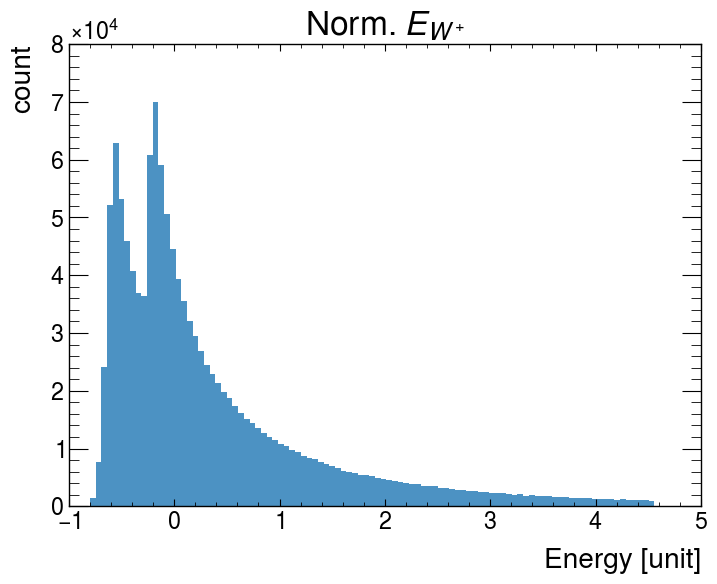

In [15]:
plt.hist(int_kin[:, 0], bins=100, alpha=.8)
plt.title("Norm." + r" $E_{W^+}$")
plt.xlabel("Energy [unit]")
plt.ylabel("count")
# plt.xlim([0,800])
plt.show()
# plt.hist(int_kin[:, 1], bins=100, alpha=.8)
# plt.title("Norm." + r" $E_{W^-}$")
# plt.xlabel("Energy [unit]")
# plt.ylabel("count")
# # plt.xlim([0,800])
# plt.show()

In [16]:
indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.4,
    test_size=0.6,
    random_state=seed,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=42
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (509324, 10);
Validing data shape: (381993, 10);
Testing data shape: (381994, 10).
Y (Observed)
Training data shape: (509324, 1);
Validing data shape: (381993, 1);
Testing data shape: (381994, 1).



In [11]:
# # Define the generator function of the dataset.
# def data_gen(X_data, y_data, indices):
#     while True:
#         for start in range(0, len(indices), batch_size):
#             end = min(start + batch_size, len(indices))
#             # print(f"start: {start}, end: {end}, indices: {indices[start:end]}")
#             # print(f"X_data shape: {X_data.shape}, y_data shape: {y_data.shape}")
#             yield X_data[indices[start:end]], y_data[indices[start:end]]

In [17]:
# Define a new activation function
def custom_activation(x):
    return x*tf.keras.backend.sigmoid(x)

# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=512, activation="elu")(x)
    x = tf.keras.layers.Dense(units=512, activation="elu")(x)
    x = tf.keras.layers.Dense(units=128, activation="elu")(x)
    x = tf.keras.layers.Dense(units=128, activation="elu")(x)
    
    # Last dense layer
    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear")(x)

    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
    )

    # Summarize the model
    model.summary()

    return model

In [18]:
model = build_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 512)               5632      
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 1)                 129   

In [19]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    callbacks=[stop_early],
)

Epoch 1/512
3980/3980 - 19s - loss: 0.3194 - val_loss: 0.3117 - 19s/epoch - 5ms/step
Epoch 2/512
3980/3980 - 16s - loss: 0.3050 - val_loss: 0.3018 - 16s/epoch - 4ms/step
Epoch 3/512
3980/3980 - 17s - loss: 0.3003 - val_loss: 0.2982 - 17s/epoch - 4ms/step
Epoch 4/512
3980/3980 - 17s - loss: 0.2981 - val_loss: 0.2979 - 17s/epoch - 4ms/step
Epoch 5/512
3980/3980 - 16s - loss: 0.2964 - val_loss: 0.2946 - 16s/epoch - 4ms/step
Epoch 6/512
3980/3980 - 16s - loss: 0.2951 - val_loss: 0.2951 - 16s/epoch - 4ms/step
Epoch 7/512
3980/3980 - 17s - loss: 0.2943 - val_loss: 0.2933 - 17s/epoch - 4ms/step
Epoch 8/512
3980/3980 - 16s - loss: 0.2933 - val_loss: 0.2949 - 16s/epoch - 4ms/step
Epoch 9/512
3980/3980 - 17s - loss: 0.2923 - val_loss: 0.2921 - 17s/epoch - 4ms/step
Epoch 10/512
3980/3980 - 17s - loss: 0.2915 - val_loss: 0.2949 - 17s/epoch - 4ms/step
Epoch 11/512
3980/3980 - 17s - loss: 0.2907 - val_loss: 0.2930 - 17s/epoch - 4ms/step
Epoch 12/512
3980/3980 - 17s - loss: 0.2898 - val_loss: 0.2941 

In [20]:
# save model
model.save("DNN_modified_w_e.h5", save_format="h5", overwrite=True)
# predict
pred_y = model.predict(test_x)
sig_pred = pred_y
sig_truth = test_y

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11938/11938 [==============================] - 14s 1ms/step


In [21]:
print(f"Truth mean: {np.mean(sig_truth[:,0]):.3f}, std: {np.std(sig_truth[:,0]):.3f}, min: {np.min(sig_truth[:,0]):.3f}, max: {np.max(sig_truth[:,0]):.3f}")

Truth mean: 0.353, std: 1.013, min: -0.832, max: 4.557


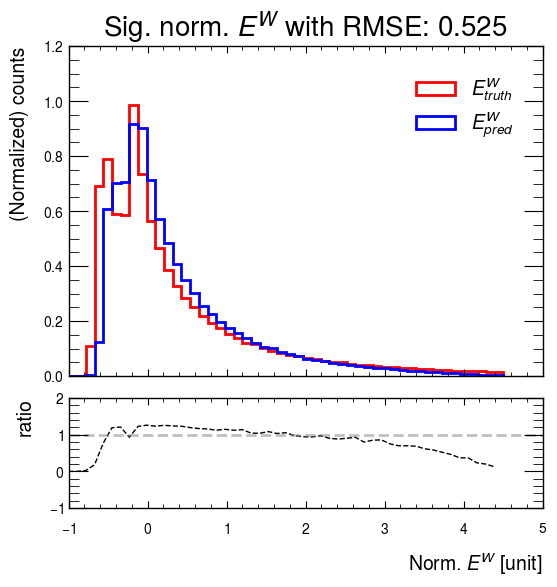

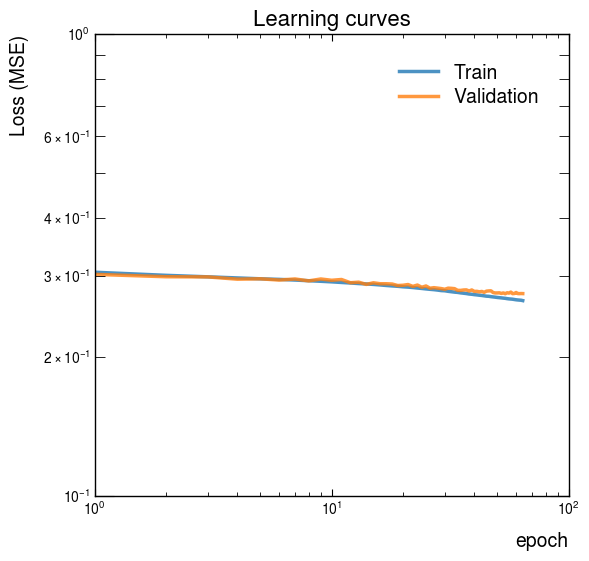

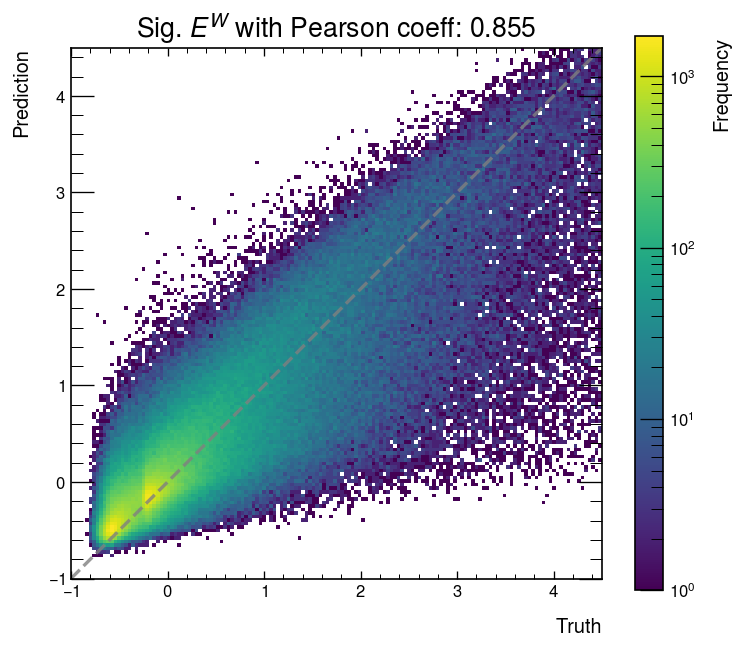

In [22]:
range = [-1, 4.5]

plot.plot_hist(
    [sig_truth[:, 0], sig_pred[:, 0]],
    [r"$E_{truth}^{W}$", r"$E_{pred}^{W}$"],
    r"Sig. norm. $E^{W}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
    range=range,
    xlabel=r"Norm. $E^{W}$ [unit]",
)

# plot.plot_hist(
#     [sig_truth[:, 1], sig_pred[:, 1]],
#     [r"$E_{truth}^{W^-}$", r"$E_{pred}^{W^-}$"],
#     r"Sig. norm. $E^{W^-}$"
#     + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
#     range=range,
#     xlabel=r"Norm. $E^{W^-}$ [unit]",
# )

plot.plot_loss_history(history, logx=True, logy=True)

plot.plot_2d_histogram(
    sig_truth[:, 0],
    sig_pred[:, 0],
    r"Sig. $E^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
    range=range,
)
# plot.plot_2d_histogram(
#     sig_truth[:, 1],
#     sig_pred[:, 1],
#     r"Sig. $E^{W^-}$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,1], sig_pred[:,1])[0]:.3f}",
#     range=range,
# )

In [18]:
# TODO

In [19]:
# from sklearn.metrics import mean_squared_error

# range = [0.43, 0.57]
35042

# plot.plot_hist(
#     [sig_truth[:, 0], sig_pred[:, 0]],
#     [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
#     r"Sig. norm. $p^{\nu\nu}_{z}$" + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
#     range=range,
#     xlabel=r"[Norm. $p_{z}$ unit]",
# )

# plot.plot_loss_history(history, logx=True, logy=True)

# plot.plot_2d_histogram(
#     sig_truth[:, 0],
#     sig_pred[:, 0],
#     r"Sig. $p_{z}^{\nu\nu}$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
#     range=range,
# )

35042

In [20]:
# Background
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/data/truth/background/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/data/truth/background/CGLMP.npz', '/root/data/truth/background/Higgs.npz', '/root/data/truth/background/LeadLepton.npz', '/root/data/truth/background/LeptonM.npz', '/root/data/truth/background/LeptonP.npz', '/root/data/truth/background/LmNu.npz', '/root/data/truth/background/LpNu.npz', '/root/data/truth/background/MET.npz', '/root/data/truth/background/WmBoson.npz', '/root/data/truth/background/WpBoson.npz', '/root/data/truth/background/diLepton.npz', '/root/data/truth/background/subLeadLepton.npz', '/root/data/truth/background/xi_xyz.npz']



In [21]:
# inputs -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
obs_kin = pd.concat([MET, lep_kin], axis=1)
print("obs_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print()

# targets -> interested unknowns
int_kin = pd.DataFrame(
    processor.process_dipart(data.NuP, data.NuM)[["pz"]][cut_pre]
)
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

/tmp/ipykernel_170573/3122629841.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lep_p = processor.process_part(data.LepP)[cut_pre]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
# SCALAR_obs_std_bkg = StandardScaler()
# obs_kin = SCALAR_obs_std_bkg.fit_transform(obs_kin)
SCALAR_obs_qt_bkg = QuantileTransformer(output_distribution='normal')
obs_kin = SCALAR_obs_qt_bkg.fit_transform(obs_kin)

# SCALAR_int_std_bkg = StandardScaler()
# int_kin = SCALAR_int_std_bkg.fit_transform(int_kin)
SCALAR_int_qt_bkg = QuantileTransformer(output_distribution='normal')
int_kin = SCALAR_int_qt_bkg.fit_transform(int_kin)

x, y = obs_kin[indices_arr], int_kin[indices_arr]

print(f"X:\ndata shape: {x.shape};\nY:\ndata shape: {y.shape}.")
print()

In [ ]:
y_pred = model.predict(x)
bkg_pred = y_pred
bkg_truth = y

In [ ]:
range = [
    np.max([bkg_pred[:, 0].min(), bkg_truth[:, 0].min()]),
    np.min([bkg_pred[:, 0].max(), bkg_truth[:, 0].max()]),
]

plot.plot_hist(
    [bkg_truth[:, 0], bkg_pred[:, 0]],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    "Non-resnt WW: " + r"Normalized $E$ of $\nu\nu$",
    range=range,
    xlabel=r"$E$ [GeV]",
)

plot.plot_2d_histogram(
    bkg_pred[:, 0],
    bkg_truth[:, 0],
    "Non-resnt WW: "
    + r"$E^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(bkg_truth[:,0], bkg_pred[:,0])[0]:.3f}",
    range=range,
)

In [ ]:
range = [
    np.max([bkg_pred[:, 1].min(), bkg_truth[:, 1].min()]),
    np.min([bkg_pred[:, 1].max(), bkg_truth[:, 1].max()]),
]

plot.plot_hist(
    [bkg_truth[:, 1], bkg_pred[:, 1]],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    r"Non-resnt WW: Normalized $p_{z}$ of $\nu\nu$",
    range=range,
    xlabel=r"$p_{z}$ [GeV]",
)

plot.plot_2d_histogram(
    bkg_truth[:, 1],
    bkg_pred[:, 1],
    "Non-resnt WW: "
    + r"$p_{z}^{\nu\nu}$"
    + f" with Pearson coeff: {sp.stats.pearsonr(bkg_truth[:,1], bkg_pred[:,1])[0]:.3f}",
    range=range,
)

time_end = time()
print(f"Time cost: {(time_end - time_start):.2f} s.")